# Bayesian SIR

Antonio Feltrin, Giosuè Sardo Infirri, Riccardo Tancredi, Simone Toso


## Scaletta
 - MCMC con un solo parametro

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import gamma as gammafunc
from scipy.stats import gamma as gammadist

## Data generation

In [62]:
#Parameter initialization
N = int(1e6)
T = 101
I0 = 50
beta_true = 0.3
gamma_true = 0.05

betas = T*[beta_true]
gammas = T*[gamma_true]

#Simulation
initial_conf = np.array([N-I0, I0, 0])

configurations = np.zeros([T, 3])
configurations[0, :] = initial_conf

for tt in range(1, T):
    beta_true = betas[tt]
    gamma_true = gammas[tt]
    
    delta_I = npr.binomial(configurations[tt-1][0],
                           1 - np.exp(-beta_true*configurations[tt-1][1]/N))
    delta_R = npr.binomial(configurations[tt-1][1],
                           gamma_true)
    configurations[tt][0] = configurations[tt-1][0] - delta_I
    configurations[tt][1] = configurations[tt-1][1] + delta_I - delta_R
    configurations[tt][2] = configurations[tt-1][2] + delta_R

Text(0.5, 1.0, 'Simulated data with varying parameters')

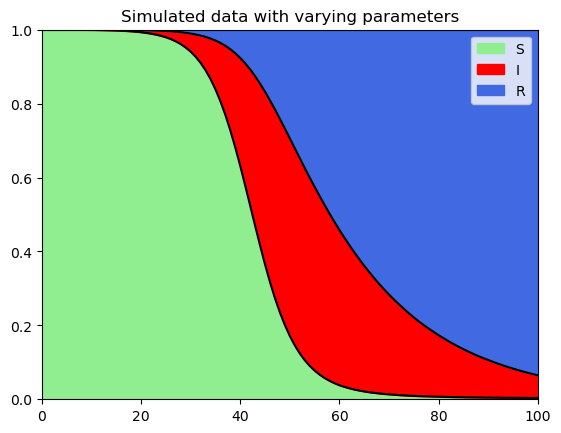

In [63]:
xs = np.arange(0, T)
ss = configurations[:, 0] / N
ii = configurations[:, 1]/N + ss
rr = configurations[:, 2]/N + ii

plt.plot(ss, c = "black")
plt.plot(ii, c = "black")
plt.plot(rr, c = "black")
plt.ylim([0, 1])

plt.fill_between(xs, 0, ss, label = "S", color = "lightgreen")
plt.fill_between(xs, ss, ii, label = "I", color = "red")
plt.fill_between(xs, ii, rr, label = "R", color = "royalblue")

plt.xlim([0, T-1])
plt.legend()
plt.title("Simulated data with varying parameters")

## MCMC

 - Update delta
 - Update b,r
 - Update gamma

In [64]:
def mylog(x):
    res = np.where(x != 0, np.log(x), -1022)
    return res


In [65]:
np.shape(configurations)

(101, 3)

### Delta update

In [66]:
def conditional_betagamma(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        total += 2*mylog(gammafunc(0.1 + np.sum(eta == ii)))
        total -= mylog(0.1 + np.sum(beta*(eta==ii)))*(0.1 + np.sum(eta == ii))
        total -= mylog(0.1 - np.sum(mylog(gamma)*(eta==ii)))*(0.1 + np.sum(eta == ii))
    return total

def JJ(delta_proposed, delta_now, T):
    
    sum_proposed = np.sum(delta_proposed).astype(int)
    sum_now = np.sum(delta_now).astype(int)
    
    if sum_proposed == sum_now:
        return 1
    elif sum_proposed == 1 and sum_now == 2:
        return 3/(T-1)
    elif sum_proposed == T and sum_now == T-1:
        return 3/(T-1)
    elif sum_proposed == 2 and sum_now == 1:
        return (T-1)/3
    elif sum_proposed == T-1 and sum_now == T:
        return (T-1)/3
    elif sum_proposed < sum_now:
        return (sum_now - 1)/(T-sum_proposed)
    else:
        return (T- sum_now) / (sum_proposed - 1)
    
def update_delta(delta_proposed, delta_now, beta_now, gamma_now, p, T):
    #Step 1: evaluate first term pi/pi
    difference = np.sum(delta_proposed - delta_now)
    first_term = difference*mylog(p/(1-p))
    
    #Step 2: evaluate second term:
    second_term = conditional_betagamma(delta_proposed, beta_now, gamma_now)
    second_term -= conditional_betagamma(delta_now, beta_now, gamma_now)
    
    #Step 3: evaluate third term
    third_term = mylog(JJ(delta_proposed, delta_now, T))
    
    log_m = first_term + second_term + third_term
    
    probability = np.exp(min(0, log_m))
    
    eps = npr.uniform() 
    if eps < probability:
        return delta_proposed
    else:
        return delta_now
    
def propose_delta(delta_now, T):
    K = np.sum(delta_now).astype(int)
    delta = delta_now.copy()
    if K == 1:
        probs = np.array([1,0,0])
    elif K==T:
        probs = np.array([0,1,0])
    else:
        probs = np.array([1,1,1])/3
        
    choice = npr.choice([0,1,2], p = probs)
    
    if choice == 0: #add
        index = npr.choice(np.where(delta_now == 0)[0])
        delta[index] += 1
    elif choice == 1: #delete
        index = npr.choice(np.where(delta_now == 1)[0])
        delta[index] -= 1
    else:
        index_0 = npr.choice(np.where(delta_now == 0)[0])
        index_1 = npr.choice(np.where(delta_now == 1)[0])
        delta[index_0] = 1
        delta[index_1] = 0
    
    return delta  

In [67]:
# Try one step
p = .01
T = 100

# Initialize delta
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

delta_1 = propose_delta(delta_0, T)
prova = update_delta(delta_1, delta_0, beta_0, gamma_0, p, T)

delta_1 = prova

GAMMA_0 [0.95651627 0.6554454  0.91910438 0.88141932 0.71732664 0.90469575
 0.97085635 0.9734765  0.99227714 0.97844117 0.982277   0.99576173
 0.79609043 0.82901498 0.90971268 0.79345274 0.95879725 0.93942134
 0.93246858 0.95946283 0.98319559 0.97048221 0.98848142 0.93686367
 0.95569949 0.95991908 0.9583154  0.9014545  0.90955012 0.86866864
 0.9746914  0.97264404 0.83451148 0.94512502 0.94624437 0.9192461
 0.89782083 0.98282782 0.93229372 0.87899929 0.90919311 0.90953384
 0.98503562 0.83338211 0.845979   0.75759114 0.88165468 0.9956862
 0.92632204 0.94263961 0.94287733 0.93590087 0.83194464 0.8823935
 0.94390658 0.98765301 0.67396215 0.89213596 0.97848455 0.78294798
 0.88270395 0.84982411 0.97959314 0.94051985 0.99306398 0.94576819
 0.85083742 0.92025276 0.75599043 0.81352686 0.96462581 0.98262716
 0.88628758 0.87518079 0.93185568 0.82389702 0.9579787  0.94456096
 0.8889766  0.53622041 0.98184185 0.95183902 0.96899274 0.90266967
 0.98176371 0.77668609 0.75829552 0.90523845 0.93559226 0

### b and r update

In [68]:
def update_b(delta_now, beta_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    b_next = np.zeros(K)
    for kk in range(K):
        b_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1+np.sum(beta_now*(eta==kk))))
    return b_next

def update_r(delta_now, gamma_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    r_next = np.zeros(K)
    for kk in range(K):
        r_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1 + np.sum(-mylog(gamma_now)*(eta==kk))))

    return r_next


In [69]:
#Update b, r
eta = np.cumsum(delta_1)

b_1 = update_b(delta_1, beta_0)
b_1 = b_1[eta-1]

r_1 = update_r(delta_1, gamma_0)
r_1 = r_1[eta-1]

### Update beta and gamma

In [70]:
#For each beta find a sample from posterior
def posterior_beta(x, A, C, D):
    if 1-np.exp(-x*C) <= 0:
        print(1-np.exp(-x*C))
    return -x*A+D*np.log(1-np.exp(-x*C))

#def update_beta_rejection(S, I, N, T, b):
#    new_betas = np.zeros(T)
#    for tt in range(T):
#        C = I[tt]/N
#        D = I[tt+1]-I[tt]
#        A = C*(S[tt]-D)+b[tt]
#        M_beta = 1/C*np.log(1+C*D/A)
#        if M_beta < 0:
#            M_beta = .005
#        M = posterior_beta(M_beta, A, C, D)
#        
#        sampled = False        
#        while not sampled:
#            prob = npr.uniform()
#            sample = npr.uniform()
#            if posterior_beta(sample, A, C, D) - M  >= np.log(prob):
#                sampled = True
#                new_betas[tt] = sample   
#    return new_betas

def update_beta(S, I, N, T, b): #cool beta distribution trick
    new_betas = np.zeros(T)
    for tt in range(T):
        C = I[tt]/N
        D = -S[tt+1]+S[tt]
        A = C*(S[tt]-D)+b[tt]
        y = npr.beta(a = A/C, b = D+1)
        new_betas[tt] = -1/C*np.log(y)
        
    return new_betas

def update_gamma(I, R, N, T, r):
    new_gammas = np.zeros(T)
    for tt in range(T):
        delta_R = R[tt+1]-R[tt]
        new_gammas[tt] = npr.beta(delta_R + r[tt], I[tt]-delta_R+1)
    return new_gammas

# Let's try a full run

In [83]:
n_steps = int(50000)

p = .01
T = 100

burnin = 5000
thin = 10

betas_run = np.zeros([T, n_steps])
gammas_run = np.zeros([T, n_steps])
bs_run = np.zeros([T, n_steps])
rs_run = np.zeros([T, n_steps])
deltas_run = np.zeros([T, n_steps])


# Initialize parameters
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()


for step in range(n_steps):
    if step%1000 == 0:
        print(step)

    delta_new = propose_delta(delta, T)
    delta = update_delta(delta_new, delta, beta, gamma, p, T)
    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    eta = np.cumsum(delta)
    b = b[eta-1]
    r = r[eta-1]
    
    beta = update_beta(configurations[:,0], configurations[:,1], N, T, b)
    gamma = update_gamma(configurations[:,1], configurations[:,2], N, T, r)
    
    if step >= burnin and step % thin == 0:
        betas_run[:, step] = beta
        gammas_run[:,step] = gamma
        deltas_run[:,step] = delta
        bs_run[:,step] = b
        rs_run[:,step] = r
    
    

0


/tmp/ipykernel_12915/3888476496.py:2: RuntimeWarning: divide by zero encountered in log
  res = np.where(x != 0, np.log(x), -1022)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [84]:
#Keep column which are not empty
np.shape(deltas_run)

deltas_samples = deltas_run[:, deltas_run.any(0)]
bs_samples = bs_run[:, bs_run.any(0)]
rs_samples = rs_run[:, rs_run.any(0)]
betas_samples = betas_run[:, betas_run.any(0)]
gammas_samples = gammas_run[:, gammas_run.any(0)]

### Bayesian estimator for delta

In [85]:
#Every row is a timestep
beta_mean = np.mean(betas_samples, axis = 1)
beta_mean

array([0.4695154 , 0.24721137, 0.39286595, 0.29018236, 0.38945007,
       0.36242068, 0.32196509, 0.27018058, 0.3164328 , 0.29439032,
       0.29915193, 0.35416772, 0.29511216, 0.29076834, 0.30897932,
       0.28614155, 0.30709526, 0.29352489, 0.29878107, 0.29816381,
       0.29995568, 0.30430193, 0.29852912, 0.29231621, 0.29403642,
       0.29313438, 0.30129181, 0.30117041, 0.29881202, 0.29455924,
       0.30161624, 0.29891151, 0.30145693, 0.29788576, 0.3007835 ,
       0.29784912, 0.29693307, 0.29970955, 0.29926355, 0.29855391,
       0.30049429, 0.29759682, 0.29937007, 0.29796409, 0.30145329,
       0.300826  , 0.29902382, 0.29996338, 0.29872883, 0.29922219,
       0.30177545, 0.30237482, 0.30169983, 0.30095127, 0.30375174,
       0.30129306, 0.30300309, 0.30424199, 0.30141619, 0.31093932,
       0.29380099, 0.29643122, 0.31112841, 0.30063492, 0.30729413,
       0.3076259 , 0.2868375 , 0.30696839, 0.30061684, 0.28881783,
       0.29971143, 0.30062226, 0.30499747, 0.3061695 , 0.31499

In [86]:
gamma_mean = np.mean(gammas_samples, axis = 1)
gamma_mean

array([0.03606666, 0.09393958, 0.03455528, 0.05199056, 0.06330668,
       0.04722154, 0.08471364, 0.03287891, 0.05044109, 0.03782827,
       0.05186947, 0.04544433, 0.05111564, 0.05032829, 0.04764308,
       0.03637976, 0.05195836, 0.0518276 , 0.04827345, 0.05010873,
       0.05305995, 0.05168706, 0.05099086, 0.05236467, 0.05299576,
       0.04873192, 0.05120262, 0.0517152 , 0.05140794, 0.0508558 ,
       0.05045404, 0.04903681, 0.04891944, 0.04968504, 0.04987169,
       0.04890832, 0.04899307, 0.05001756, 0.05017939, 0.04967416,
       0.04999629, 0.04936893, 0.05014334, 0.04995103, 0.05017236,
       0.05023094, 0.04972122, 0.04987107, 0.05037459, 0.04982651,
       0.05025024, 0.05002326, 0.05029739, 0.04984759, 0.04936492,
       0.04981026, 0.04982011, 0.04984178, 0.05031231, 0.04964174,
       0.04990057, 0.05015723, 0.04973744, 0.05037622, 0.04985337,
       0.04981847, 0.0506862 , 0.05007357, 0.0498701 , 0.05024025,
       0.04993706, 0.0497911 , 0.05027989, 0.05116379, 0.05059